<a href="https://colab.research.google.com/github/kamo1010/injury-big-data/blob/main/SHAP%20Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install --upgrade category_encoders

In [7]:
pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.9 MB/s eta 0:00:00


In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from category_encoders import WOEEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [9]:
bank_data = pd.read_csv("sample_data/labels.csv", sep=";")
bank_data.head(5)

,연번,년도,월,일,날,주야간,기상조건,도시,지역,사무실,...,증상,환자유형,접수시간/이륙시간,환자 인수지역,도착시간/이륙시간,환자 후송지,후송지 도착 시간,복귀 이륙/복귀도착,출동~병원,후송결과
0,1,2021,7,27,목,주,go,대전,유성,문지로,...,두통,외상,1333/1454,A,1500/1503,대전병원,1537,1613/1720,133분,사망
1,2,2021,7,26,수,주,go,계룡,엄사,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
2,3,2021,7,25,화,주,go,인재,내일,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
3,4,2021,7,25,화,주,go,인재,내일,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
4,5,2021,7,21,금,주,go,계룡,엄사,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망


In [84]:
def split_time(x):
  times = x.split('/')
  times.append(times[1][:2])
  times.append(times[1][2:])
  times[1]=times[0][2:]
  times[0]=times[0][:2]
  return pd.Series(times)

bank_data = pd.read_csv("sample_data/labels.csv", sep=";")
bank_data.head(5)

#step 0
bank_data.rename(columns = {'연번':'id'}, inplace = True)
bank_data.rename(columns = {'년도':'year', '월':'month', '일':'day'}, inplace = True)
bank_data.rename(columns = {'날':'day of week', '주야간':'day night', '기상조건':'weather'}, inplace = True)
bank_data.rename(columns = {'도시':'city', '지역':'region', '사무실':'location'}, inplace = True)
bank_data.rename(columns = {'급':'position', '증상':'wound', '환자유형':'patient type'}, inplace = True)
bank_data.rename(columns = {'환자 인수지역':'patient acceptance area', '환자 후송지':'patient transfer area'}, inplace = True)
bank_data.rename(columns = {'후송지 도착 시간':'time of arrival at transfer area'}, inplace = True)

# step 1
bank_data = bank_data.drop(columns=["id"])
bank_data.insert(0, "date", pd.to_datetime(bank_data[["year", "month", "day"]]))

#step 2
bank_data.insert(1, "season", bank_data['month'].map({1:3, 2:3, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:2, 10:2, 11:2, 12:3}))
bank_data['day of week'] = bank_data['day of week'].map({'월':0, '화':1, '수':2, '목':3, '금':4, '토':5, '일':6})
bank_data['day night'] = bank_data['day night'].map({'주':0, '야':1})
bank_data['weather'] = bank_data['weather'].map({'no-go':0, 'go':1})

#step 6
bank_data[["registration hour", "registration minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['접수시간/이륙시간']), axis=1)
bank_data.insert(11, "registration time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["registration hour"], 'minute': bank_data["registration minute"]})).astype(int))
bank_data.insert(12, "hospital takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['registration hour']).drop(columns=['registration minute']).drop(columns=['접수시간/이륙시간'])

bank_data[["arrival hour", "arrival minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['도착시간/이륙시간']), axis=1)
bank_data.insert(13, "location arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data.insert(14, "patient takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['takeoff hour']).drop(columns=['takeoff minute']).drop(columns=['도착시간/이륙시간'])

bank_data[["departure hour", "departure minute", "arrival hour", "arrival minute"]]= bank_data.apply(lambda x: split_time(x['복귀 이륙/복귀도착']), axis=1)
bank_data.insert(15, "recovery departure time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["departure hour"], 'minute': bank_data["departure minute"]})).astype(int))
bank_data.insert(16, "recovery arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data = bank_data.drop(columns=['departure hour']).drop(columns=['departure minute']).drop(columns=['arrival hour']).drop(columns=['arrival minute']).drop(columns=['복귀 이륙/복귀도착'])

bank_data[["arrival hour", "arrival minute"]]= pd.Series([bank_data['time of arrival at transfer area']//100, bank_data['time of arrival at transfer area']%100])
bank_data["time of arrival at transfer area"] = pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int)
bank_data = bank_data.drop(columns=['arrival hour']).drop(columns=['arrival minute'])
bank_data = bank_data.drop(columns=['year', 'month', 'day', 'date'])

#step 7
bank_data.rename(columns = {'출동~병원':'waiting delay'}, inplace = True)
bank_data["waiting delay"]= (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["registration time"])).astype(int)
bank_data.insert(20, "transfer delay", (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["patient takeoff time"])).astype(int))

#step 8
bank_data.rename(columns = {'후송결과': 'y'}, inplace = True)
bank_data['y'] = bank_data['y'].map({'사망':0, '생존':1})

#step 9
levels={'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8, 'i':9, 'j':10, 'k':11, 'l':12, 'm':13, 'n':14, 'o':15, 'p':16, 'q':17, 'r':18, 's':19, 't':20}
bank_data["position"] = bank_data["position"].map(levels)
columns={"city", "region", "location", "wound", "patient type", "patient acceptance area", "patient transfer area"}
for col in columns:
  tmp = {}
  idx = 0
  for elt in bank_data[col]:
    if (elt not in tmp):
      tmp[elt] = idx
      idx+=1
  bank_data[col] = bank_data[col].map(tmp)

bank_data.head()

,season,day of week,day night,weather,city,region,location,registration time,hospital takeoff time,location arrival time,...,recovery arrival time,position,wound,patient type,patient acceptance area,patient transfer area,time of arrival at transfer area,waiting delay,transfer delay,y
0,1,3,0,1,0,0,0,1627392780000000000,1627397640000000000,1627398000000000000,...,1627406400000000000,4,0,0,0,0,1627400220000000000,7440000000000,2040000000000,0
1,1,2,0,1,1,1,0,1627306380000000000,1627307040000000000,1627311000000000000,...,1627320000000000000,4,0,0,0,0,1627313820000000000,7440000000000,2040000000000,0
2,1,1,0,1,2,2,0,1627219980000000000,1627220640000000000,1627224600000000000,...,1627233600000000000,1,0,0,0,0,1627227420000000000,7440000000000,2040000000000,0
3,1,1,0,1,2,2,0,1627219980000000000,1627220640000000000,1627224600000000000,...,1627233600000000000,1,0,0,0,0,1627227420000000000,7440000000000,2040000000000,0
4,1,4,0,1,1,1,0,1626874380000000000,1626875040000000000,1626879000000000000,...,1626888000000000000,3,0,0,0,0,1626881820000000000,7440000000000,2040000000000,0


In [18]:
cat_var = ["day night","weather"]
con_var = ['day of week', 'registration time', 'hospital takeoff time', 'location arrival time', 'patient takeoff time', 'recovery departure time',
           'recovery arrival time', 'time of arrival at transfer area', 'waiting delay', 'transfer delay', "city", "region", "position", "location", "wound", "patient type", "patient acceptance area", "patient transfer area"]

day of week
registration time
hospital takeoff time
location arrival time
patient takeoff time
recovery departure time
recovery arrival time
time of arrival at transfer area
waiting delay
transfer delay
city
region
position
location


LinAlgError: ignored

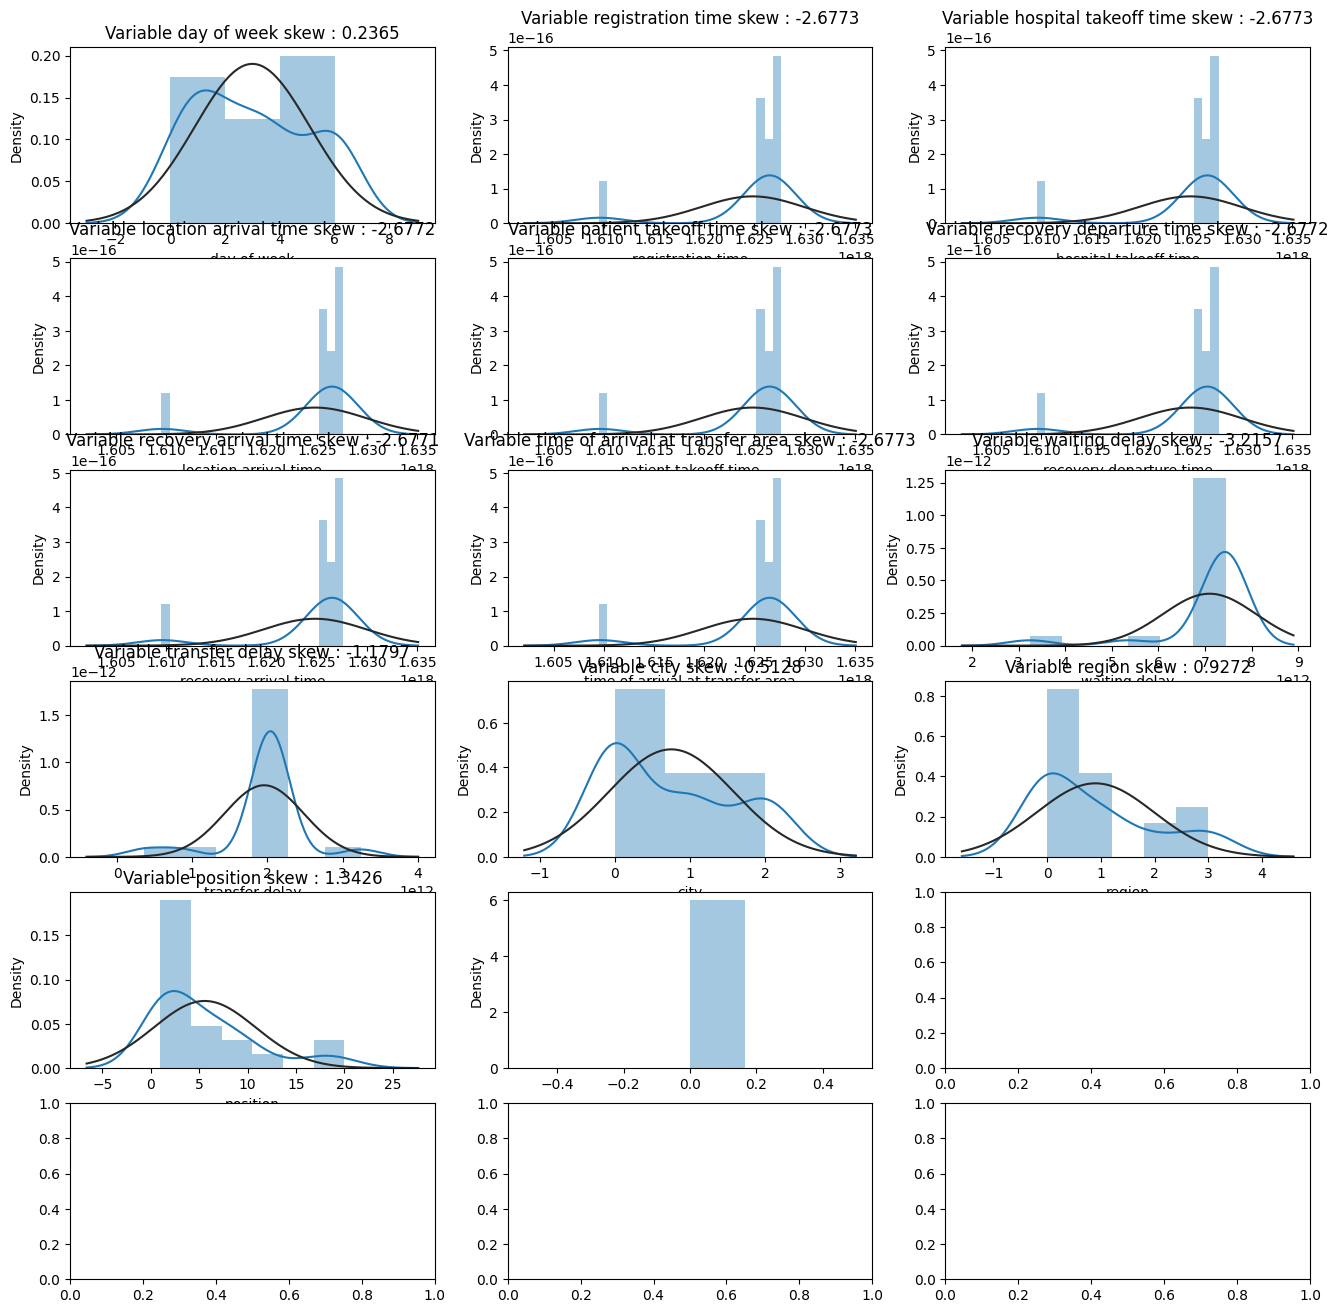

In [19]:
def con_plot(var):
    fig, ax = plt.subplots(int(np.ceil(len(con_var)/3)), 3, figsize=(16,16))
    ax = ax.flatten()
    i = 0
    for col in var:
        skew = bank_data[col].skew()
        print(col)
        sns.distplot(bank_data[col], fit = stats.norm, ax=ax[i])
        ax[i].set_title("Variable %s skew : %.4f"%(col, skew))
        i+=1
    plt.tight_layout()
    plt.show()

con_plot(con_var)

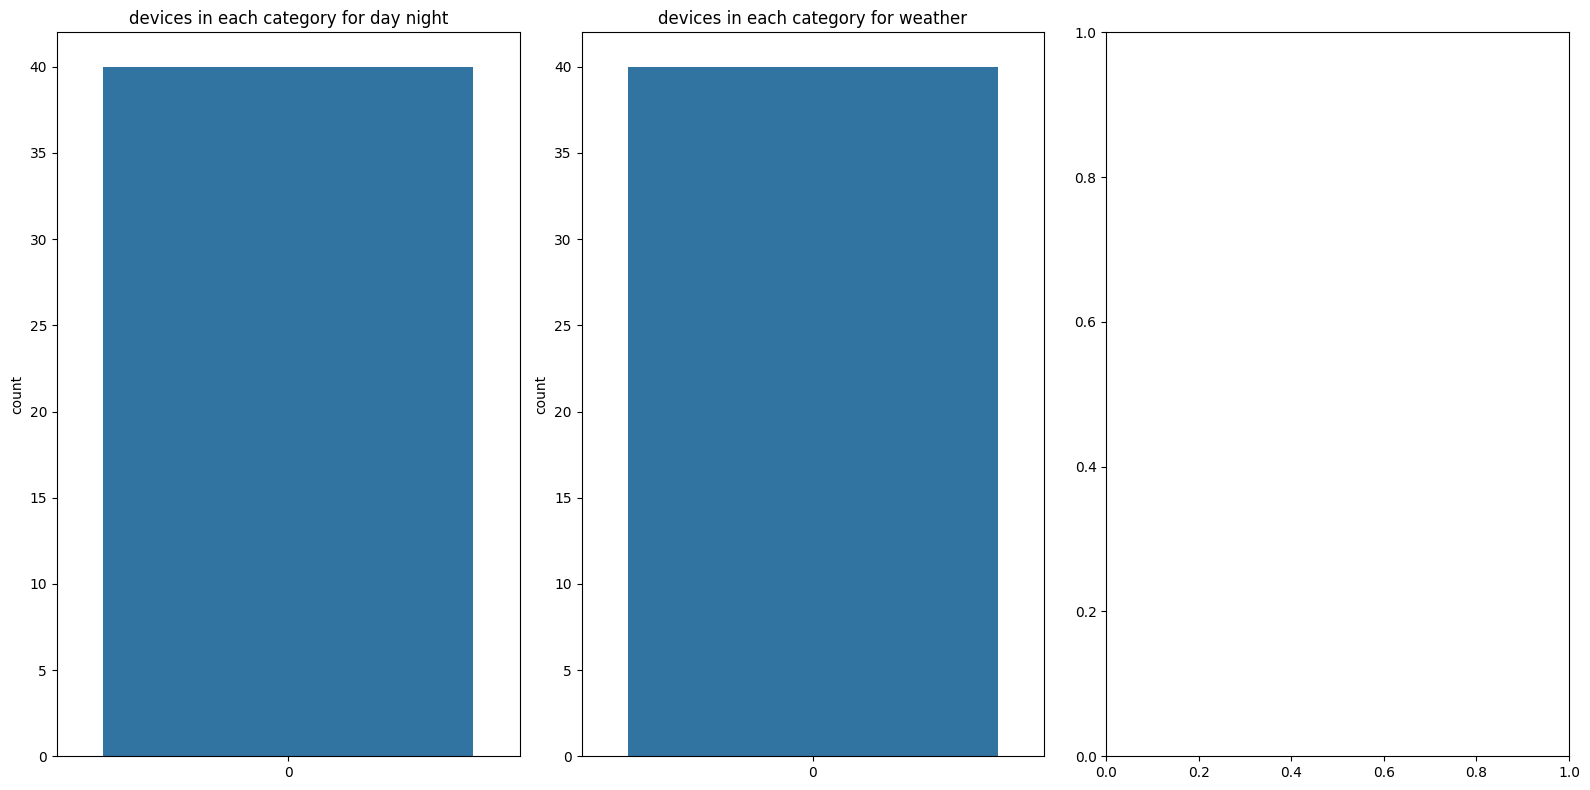

In [20]:
def cat_plot(var):
    fig, ax = plt.subplots(int(np.ceil(len(var)/3)), 3, figsize=(16,8))
    ax = ax.flatten()
    i = 0
    for col in var:
        sns.countplot(bank_data[col], ax=ax[i])
        ax[i].set_title("devices in each category for %s"%(col))
        i+=1
    plt.tight_layout()
    plt.show()

cat_plot(cat_var)

In [21]:
bank_data.isna().sum()

season                              0
day of week                         0
day night                           0
weather                             0
city                                0
region                              0
location                            0
registration time                   0
hospital takeoff time               0
location arrival time               0
patient takeoff time                0
recovery departure time             0
recovery arrival time               0
position                            0
wound                               0
patient type                        0
patient acceptance area             0
patient transfer area               0
time of arrival at transfer area    0
waiting delay                       0
transfer delay                      0
y                                   0
dtype: int64

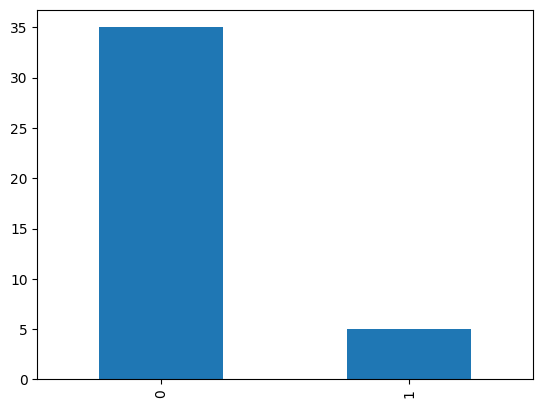

In [22]:
bank_data.y.value_counts().plot(kind='bar')
plt.show()

In [23]:
bank_data.skew()

season                              2.771708
day of week                         0.236493
day night                           0.000000
weather                            -0.907254
city                                0.512817
region                              0.927186
location                            0.000000
registration time                  -2.677342
hospital takeoff time              -2.677282
location arrival time              -2.677224
patient takeoff time               -2.677271
recovery departure time            -2.677239
recovery arrival time              -2.677148
position                            1.342594
wound                               1.262680
patient type                        1.368929
patient acceptance area             0.000000
patient transfer area               0.000000
time of arrival at transfer area   -2.677273
waiting delay                      -3.215679
transfer delay                     -1.179665
y                                   2.357116
dtype: flo

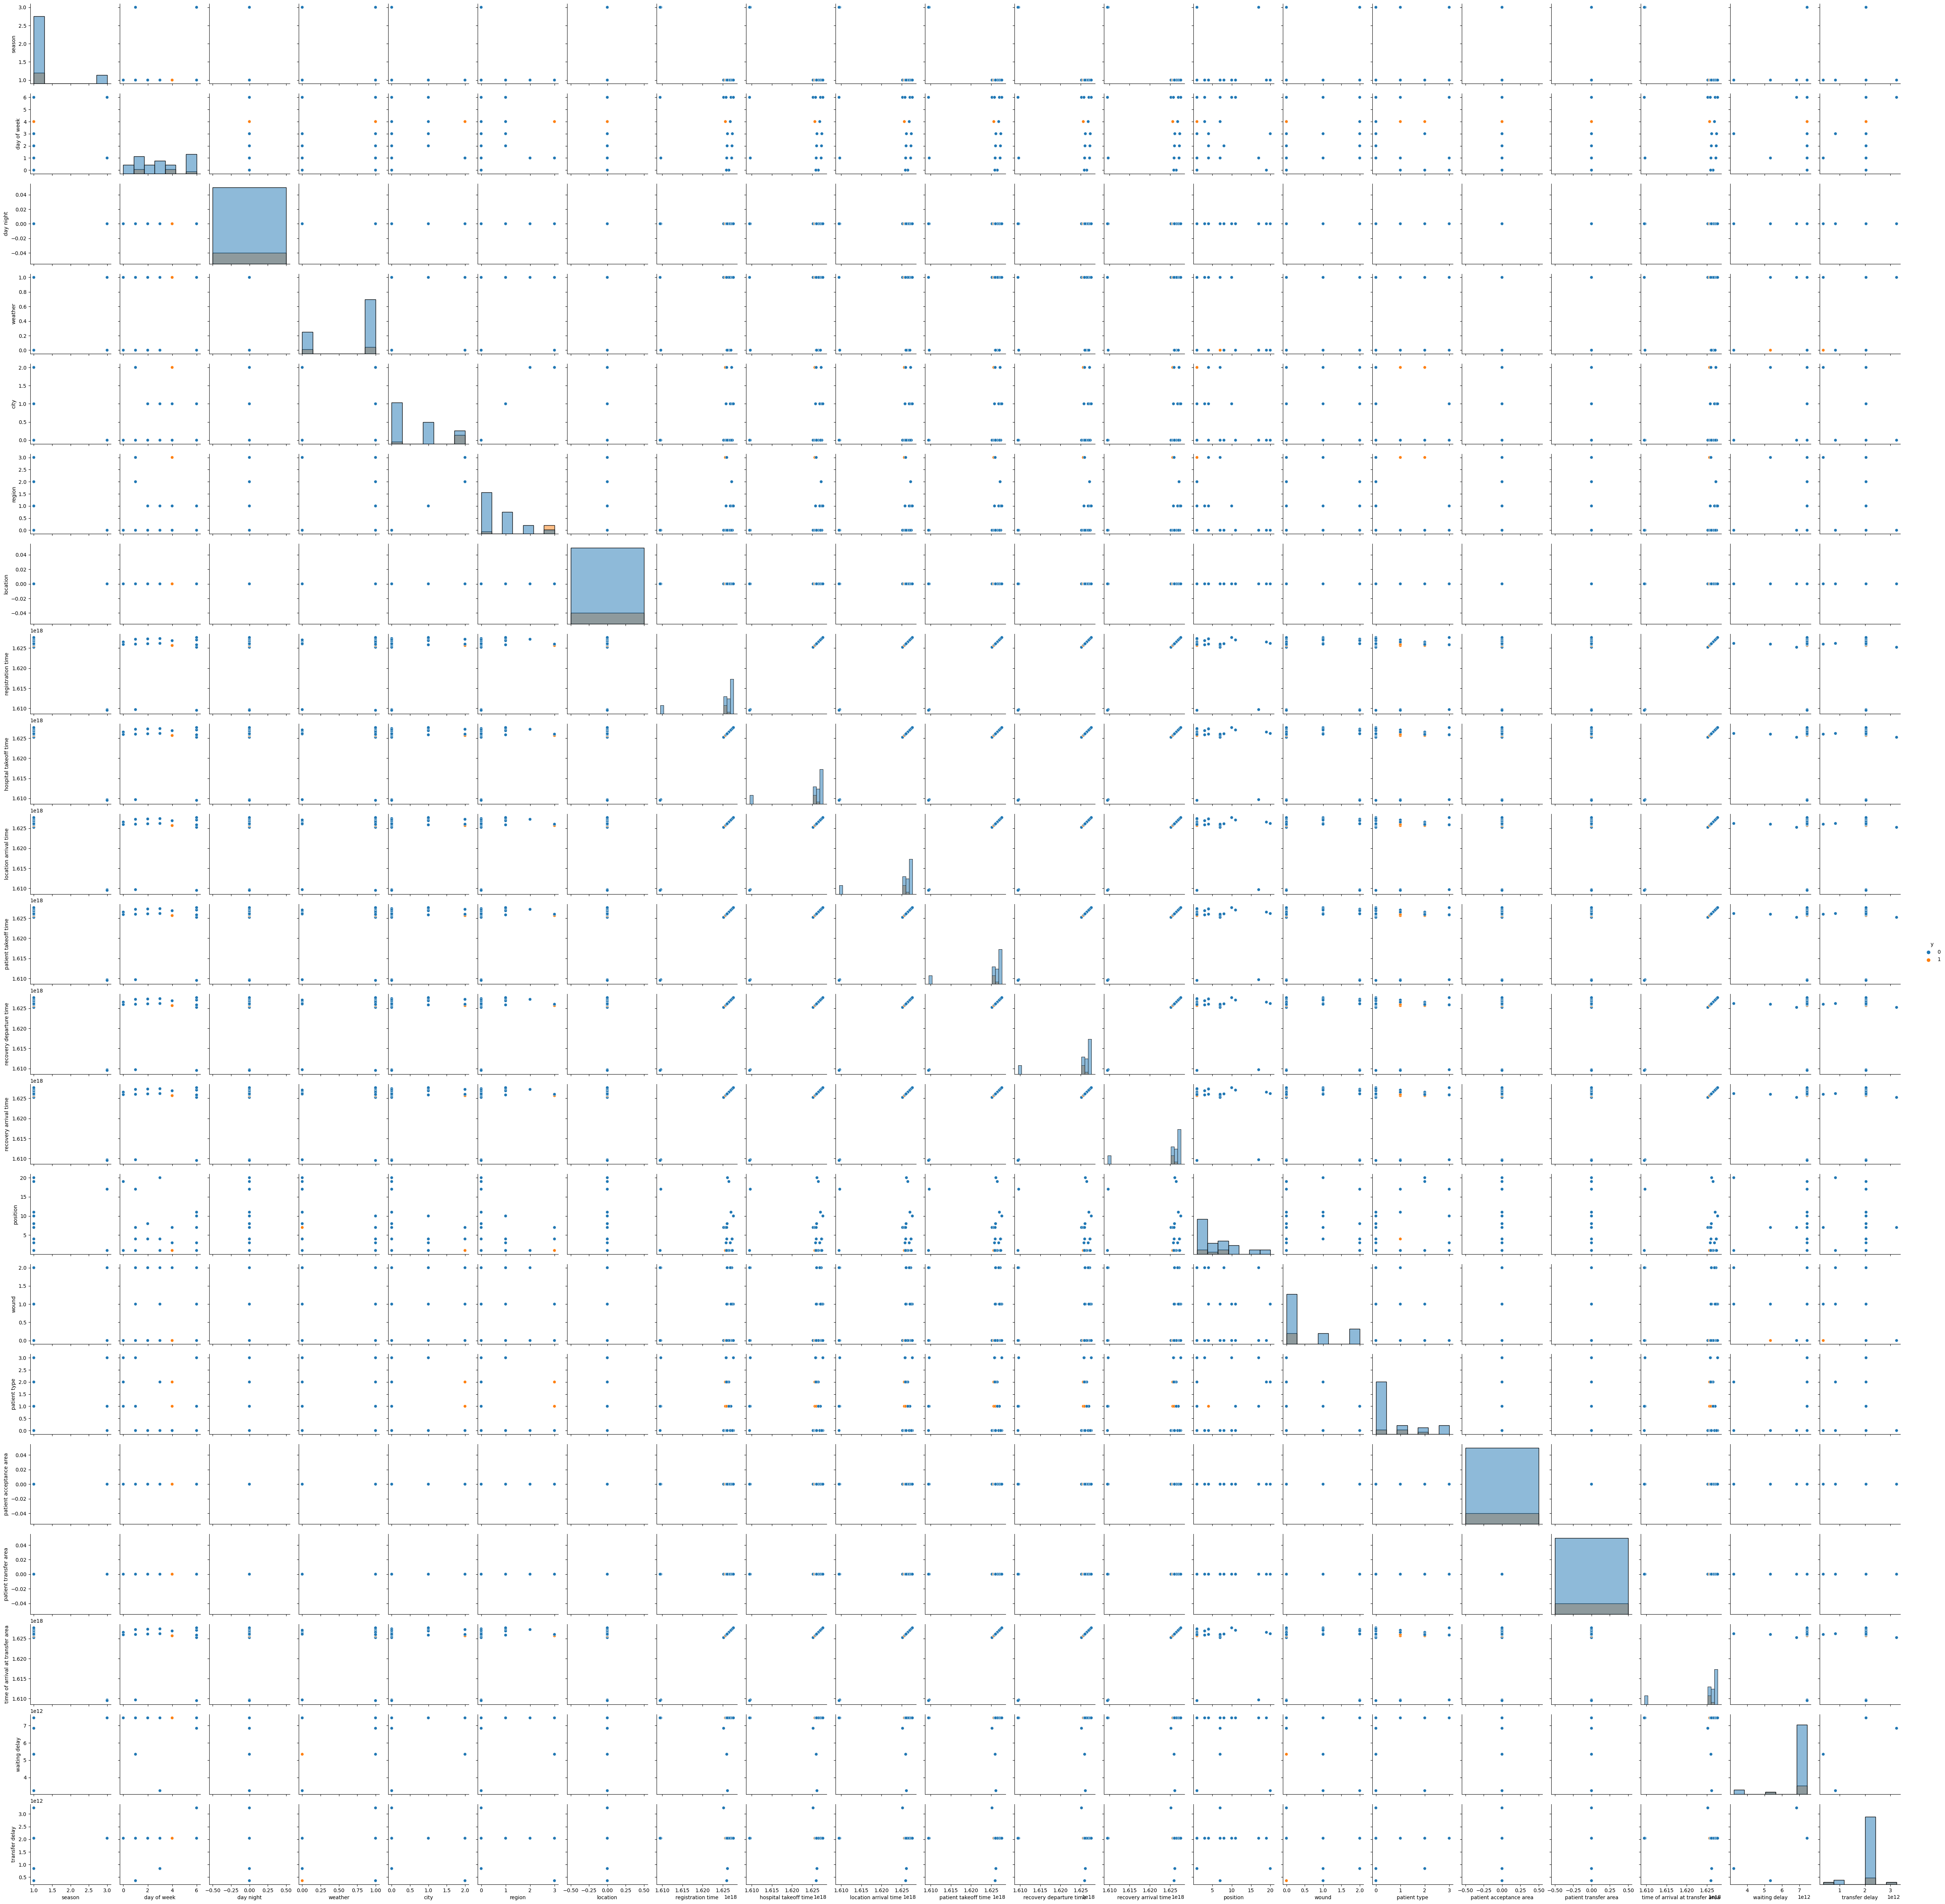

In [24]:
sns.pairplot(bank_data, hue='y', diag_kind='hist')
plt.show()

In [25]:
# Split the data into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_val = pd.DataFrame({"Col":X.columns})
vif_val["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_val

,Col,VIF
0,season,7.890488e+01
1,day of week,1.184529e+00
2,day night,NaN
3,weather,1.250683e+00
4,city,1.564785e+00
5,region,1.590488e+00
6,location,NaN
7,registration time,1.321091e+12
8,hospital takeoff time,4.595510e+13
9,location arrival time,2.394895e+12


In [102]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(k_neighbors=3)
over_X, over_y = oversample.fit_resample(X, y)

over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.3, stratify=over_y)
test = pd.concat([over_X_test, over_y_test], axis=1)

In [64]:
from statistics import mean
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier

model_rf = RandomForestClassifier(random_state=1, n_jobs=-1)
model_brf = BalancedRandomForestClassifier(n_estimators=150, random_state=2, n_jobs=-1)
model_logr = LogisticRegression(random_state=1, n_jobs=-1, multi_class='multinomial')
model_lgbm = LGBMClassifier(random_state=1, n_jobs=-1)
model_xgb = XGBClassifier(random_state=1, n_jobs=-1)
model_gbr = GradientBoostingClassifier(random_state=1)
model_cat = CatBoostClassifier(random_state=1, verbose=0)

models = []
models.append(('LR',model_logr))
models.append(('RF',model_rf))
models.append(('BRF', model_brf))
models.append(('GBR',model_gbr))
models.append(('XGB',model_xgb))
models.append(('LGB',model_lgbm))
models.append(('CAT',model_cat))

In [65]:
scaler = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
feature = SelectFromModel(model_rf, threshold=0.001)
ct = ColumnTransformer([('onehot', onehot, cat_var), ('scaler', scaler, con_var)], remainder='passthrough', n_jobs=-1)
results = []
names = []
pipelines = []
for name, model in models:
    pipe = Pipeline([('ct', ct), ('fselect', feature), (name, model)]) # including feature selection step using RF
    #pipe = Pipeline([('ct', ct), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0)
    names.append(name)
    results.append(scores)
    pipelines.append(pipe)
    print("model %s accuracy: %.4f variance: %.4f"%(name, np.mean(scores), np.std(scores)))
for i in range(len(pipelines)):
    pipe = pipelines[i]
    smote_scores = cross_val_score(pipe, over_X_train, over_y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0)
    names.append("SMOTE_"+name)
    results.append(smote_scores)
    print("model %s accuracy with SMOTE: %.4f variance: %.4f"%(names[i], np.mean(smote_scores), np.std(smote_scores)))

model LR accuracy: 0.8200 variance: 0.1833
model RF accuracy: 0.8200 variance: 0.1067
model BRF accuracy: 0.7067 variance: 0.1062
model GBR accuracy: 0.8200 variance: 0.1067
model XGB accuracy: 0.8533 variance: 0.0748
model LGB accuracy: 0.8200 variance: 0.0163
model CAT accuracy: 0.8200 variance: 0.1067
model LR accuracy with SMOTE: 0.9200 variance: 0.0400
model RF accuracy with SMOTE: 0.9200 variance: 0.0748
model BRF accuracy with SMOTE: 0.9200 variance: 0.0748
model GBR accuracy with SMOTE: 0.8800 variance: 0.1166
model XGB accuracy with SMOTE: 0.9200 variance: 0.0748
model LGB accuracy with SMOTE: 0.5333 variance: 0.0667
model CAT accuracy with SMOTE: 0.9200 variance: 0.0748


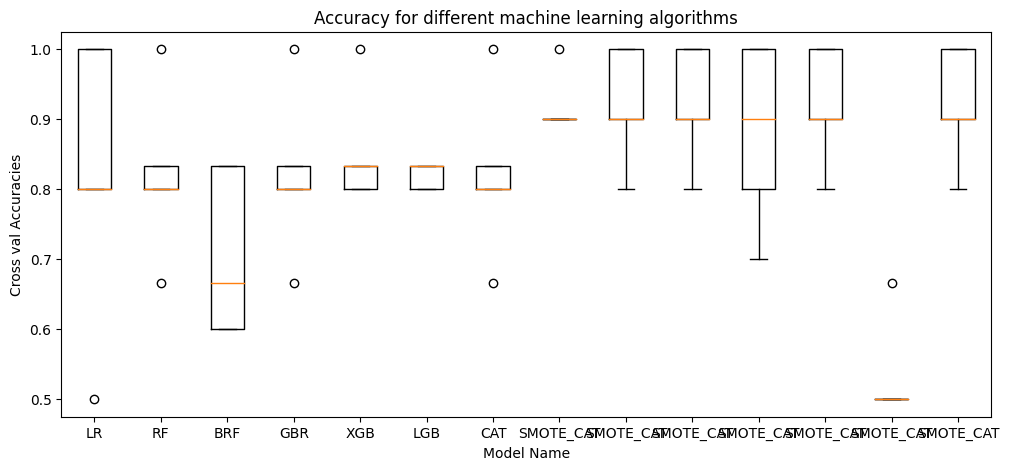

In [66]:
plt.figure(figsize=(12,5))
plt.boxplot(results)
plt.xticks(np.arange(1,len(names)+1),names)
plt.title("Accuracy for different machine learning algorithms")
plt.xlabel("Model Name")
plt.ylabel("Cross val Accuracies")
plt.show()

In [69]:
for i in range(len(models)):
  print(names[i])
  pipelines[i].fit(X_train, y_train)
  trainpred = pipelines[i].predict(X_test)
  print(classification_report(y_test, trainpred))
  print('___________________________________________________________')
  print("SMOTE_"+names[i])
  pipelines[i].fit(over_X_train, over_y_train)
  if names[i]=="RF":
  trainpred = pipelines[i].predict(over_X_test)
  print(classification_report(over_y_test, trainpred))
  print('===========================================================')

LR
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.00      0.00      0.00         0

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

___________________________________________________________
SMOTE_LR
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.73      0.84        11

    accuracy                           0.86        21
   macro avg       0.88      0.86      0.86        21
weighted avg       0.89      0.86      0.86        21

RF
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12

In [103]:
rf_pipe = RandomForestClassifier(n_estimators=150, random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(rf_pipe, over_X, over_y, cv=cv)

# Use random search to find the best hyperparameters
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

n_estimators = randint(50, 500)
max_depth= randint(1, 20)

param_dist = {'n_estimators': n_estimators, 'max_depth': max_depth}
rand_search = RandomizedSearchCV(rf_pipe, param_distributions = param_dist, cv=15)
rand_search.fit(over_X_train, over_y_train)
best_rf = rand_search.best_estimator_

# Print the best parameters
print('Best hyperparameters: ', rand_search.best_params_)

# Generate predictions with the best model
rf_y_pred = best_rf.predict(over_X_test)

sub = pd.DataFrame()

def submission(prediction, model):
    sub["y"] = prediction
    sub.y.value_counts()
    sub.to_csv("model_"+model+"_mobile_price.csv", index=False)
    return sub

sub = submission(rf_y_pred, 'rf')

Best hyperparameters:  {'max_depth': 16, 'n_estimators': 355}


In [97]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def saveTrees(rf, path):
  print("Forest population: ", len(best_rf.estimators_))

  # Export all the decision trees from the forest
  index=0
  for tree in best_rf.estimators_:
    dot_data = export_graphviz(tree, feature_names=X_train.columns, filled=True, max_depth=5, impurity=False, proportion=True)
    graph = graphviz.Source(dot_data, format="png")
    graph.render(format="png", directory=path+"trees", outfile=path+"trees/"+str(index)+".png")
    index+=1

saveTrees(rf_pipe, "img/SMOTE/")

Forest population:  229


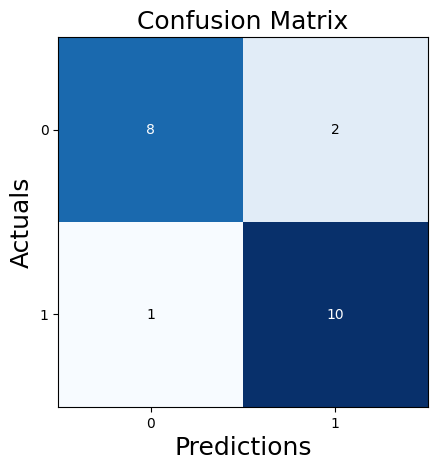

In [105]:
from mlxtend.plotting import plot_confusion_matrix

def saveConfusionMatrix(cm, path):
  fig, ax = plot_confusion_matrix(conf_mat=cm)
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.savefig(path+'confusion_matrix.png')

# Create the confusion matrix
rf_cm = confusion_matrix(over_y_test, rf_y_pred)
saveConfusionMatrix(rf_cm, "img/SMOTE/")

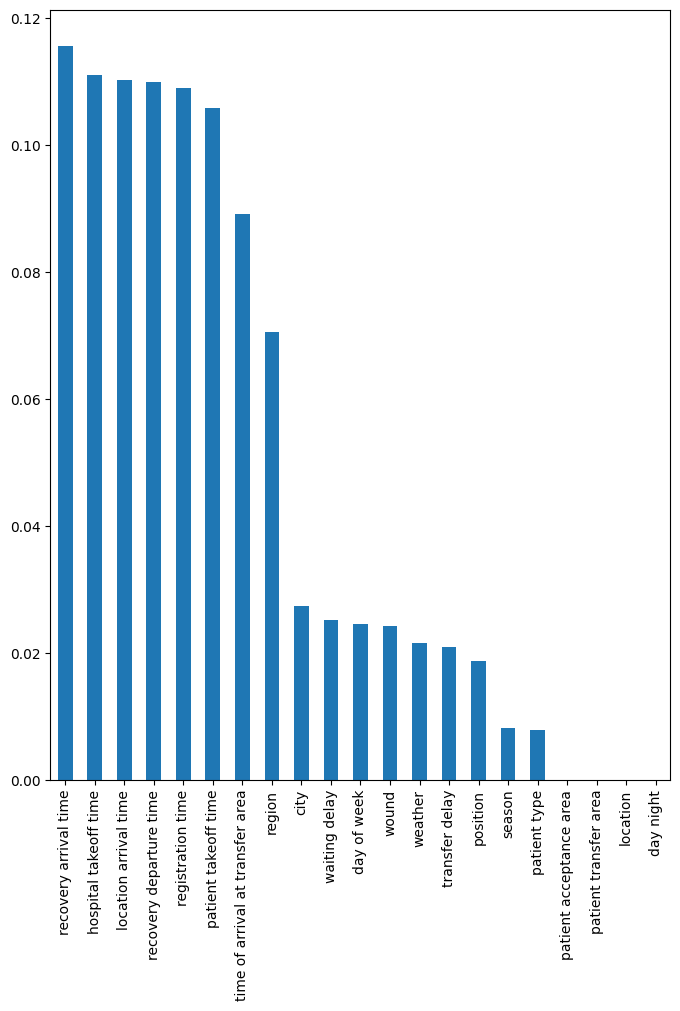

In [107]:
# Create a series containing feature importances from the model and their names from the training data
rf_feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
rf_feature_importances.plot.bar(figsize=(8,10))
plt.savefig("img/SMOTE/criteria.png", bbox_inches="tight")

In [100]:
pip install --upgrade shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.0 MB/s eta 0:00:00


In [101]:
pip install --upgrade eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=75738a2c4613d3b1f7c4b3af9d89430c7302564de72fd701663567602607a2a5
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


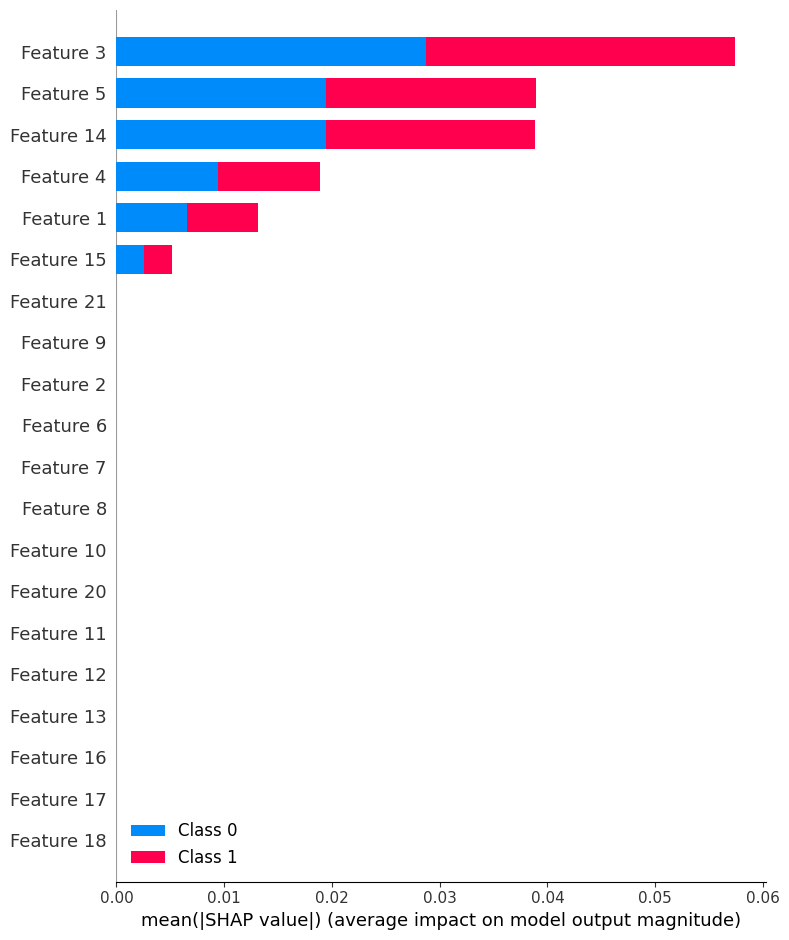

In [109]:
import shap
pd.set_option("display.max_columns",None)
shap.initjs()
import xgboost
import eli5

ct.fit(over_X)
X_shap = ct.fit_transform(over_X)
test_shap  = ct.transform(test)
explainer = shap.TreeExplainer(best_rf, X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(test_shap)
shap.summary_plot(shap_values, test_shap)